In [567]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from numpy import save
from numpy import load

In [7]:
cap = cv2.VideoCapture('DatasetC.mpg')

In [8]:
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
FPS = cap.get(cv2.CAP_PROP_FPS)
print(f'Frames: {frame_count}')
print(f'Frames per sec {FPS}')

Frames: 140.0
Frames per sec 25.0


---

Frame Differencing

Step 1: for each frame, calculate the absolute difference for each pixel location between that and the first frame:   $F_{t}$ - $F_{0}$

Step 2: Convert to grayscale 

Step 3 (Optional): Use gaussian blur

Step 4: Apply a threshold for edges

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb, [0.2989, 0.5870, 0.1140])

In [10]:
def convolve_image(image, convolution, padding=False, padding_style='constant'):

    def extend_image(image, convolution):
        im_h, im_w = image.shape[0], image.shape[1]
        rgb = 1 if len(image.shape) == 3 else 0
        conv_h, conv_w = convolution.shape[0],convolution.shape[1]
        if rgb:
            extended_image = np.zeros((im_h-conv_h+1, im_w - conv_w+1, 3, conv_h*conv_w))
        else:
            extended_image = np.zeros((im_h-conv_h+1, im_w - conv_w+1, conv_h*conv_w))
        new_im_h, new_im_w = extended_image.shape[0], extended_image.shape[1]
        for r in range(conv_h):
            for c in range(conv_w):
                if rgb:
                    extended_image[:,:,:,r*conv_h + c] = image[r:new_im_h+r,c:new_im_w+c,:]
                else:
                    extended_image[:,:,r*conv_h + c] = image[r:new_im_h+r,c:new_im_w+c]
    
        return extended_image

    if padding:
        rgb = 1 if len(image.shape) == 3 else 0
        conv_h_pad, conv_w_pad = convolution.shape[0]//2, convolution.shape[1]//2
        if rgb:
            padded_im = np.pad(image,((conv_h_pad,conv_h_pad),(conv_w_pad,conv_w_pad),(0,0)),mode=padding_style)
        else:
            padded_im = np.pad(image,((conv_h_pad,conv_h_pad),(conv_w_pad,conv_w_pad)),mode=padding_style)
    else:
        padded_im = image
    extended_image = extend_image(padded_im, convolution)
    return extended_image @ convolution.flatten()

In [11]:
def gaussian_filter(size,sigma):
    x = np.linspace(-(size//2),size//2,size)
    y = np.linspace(-(size//2),size//2,size)
    gauss = np.zeros((size,size))
    for idxx, i in enumerate(x):
        for idxy, j in enumerate(y):
            gauss[idxy,idxx] = (1/(2*np.pi*sigma**2))*np.exp(-(j**2 + i**2)/(2*sigma**2))
    return gauss/np.sum(gauss)
    return gauss

In [1105]:
cap = cv2.VideoCapture('DatasetC.mpg')
suc, frame0 = cap.read()
frame0 = frame0/255
difference_frames = []
gray_scale_difference_frames = []
gauss_filter = gaussian_filter(5,1)
blurred_gray_scale_difference_frames = []
frameT= frame0
while suc:

    difference_matrix = np.abs(frameT-frame0)
    difference_frames.append(difference_matrix.copy())
    gray_scale_difference_frames.append(rgb2gray(difference_matrix))
    blurred_gray_scale_difference_frames.append(convolve_image(rgb2gray(difference_matrix),gauss_filter))
    suc, frameT = cap.read()
    if suc:
        frameT = frameT/255

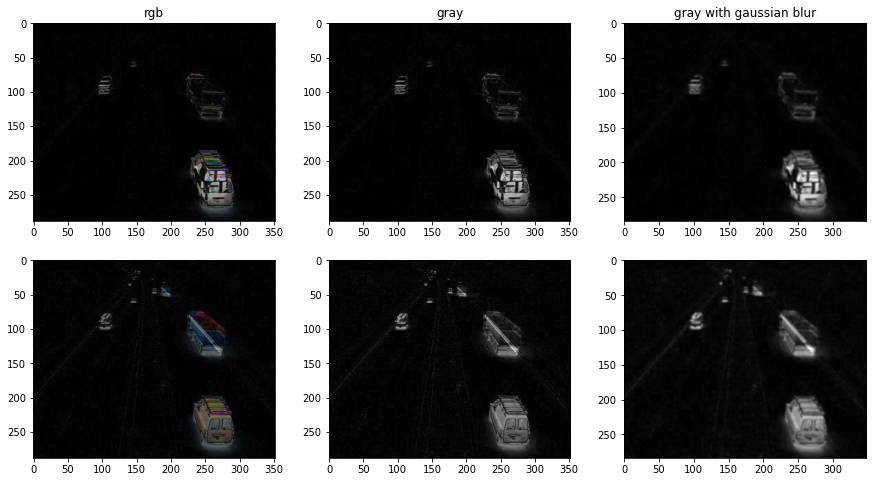

In [1106]:
def plot_images(difference_frames, gray_scale_difference_frames, blurred_gray_scale_difference_frames,frame1, frame2):
    if frame2!='null':
        fig, axlist = plt.subplots(nrows=2,ncols=3,figsize = (15,8))
    else:
        fig, axlist = plt.subplots(nrows=1,ncols=3,figsize = (15,8))
    axlist=axlist.flatten()
    axlist[0].imshow(difference_frames[frame1])
    axlist[1].imshow(gray_scale_difference_frames[frame1],'gray')
    axlist[2].imshow(blurred_gray_scale_difference_frames[frame1],'gray')
    if frame2 != 'null':
        axlist[3].imshow(difference_frames[frame2])
        axlist[4].imshow(gray_scale_difference_frames[frame2],'gray')
        axlist[5].imshow(blurred_gray_scale_difference_frames[frame2],'gray')
    axlist[0].set_title("rgb")
    axlist[1].set_title("gray")
    axlist[2].set_title("gray with gaussian blur")
    plt.show()
plot_images(difference_frames,gray_scale_difference_frames,blurred_gray_scale_difference_frames,1,80)

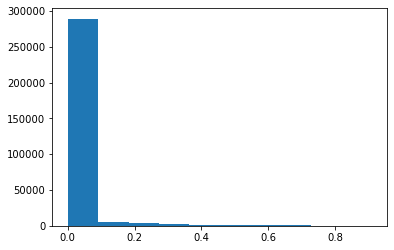

In [183]:
plt.hist(difference_frames[1].flatten()); plt.show()

----
Applying thresholding

Most values are around 0, so let's try thresholding at 0.05, 0.1, and 0.2


Plotting frames 1 and 80 for threshold: 0.05



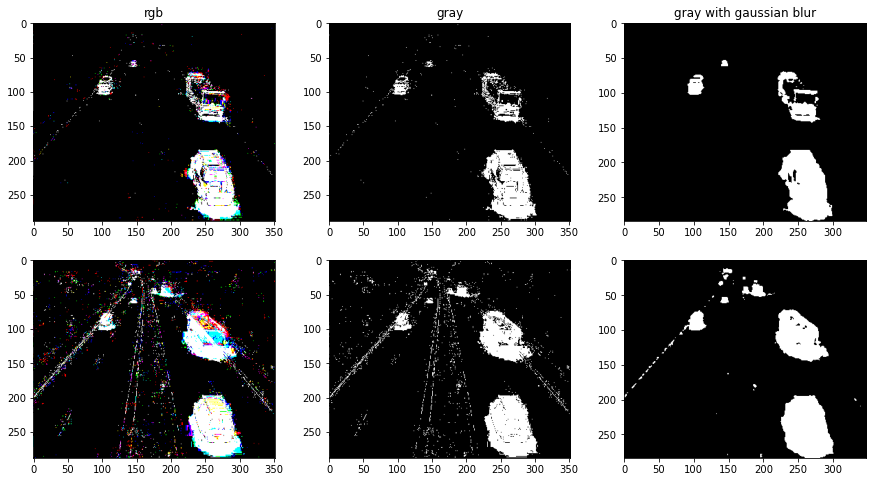


Plotting frames 1 and 80 for threshold: 0.1



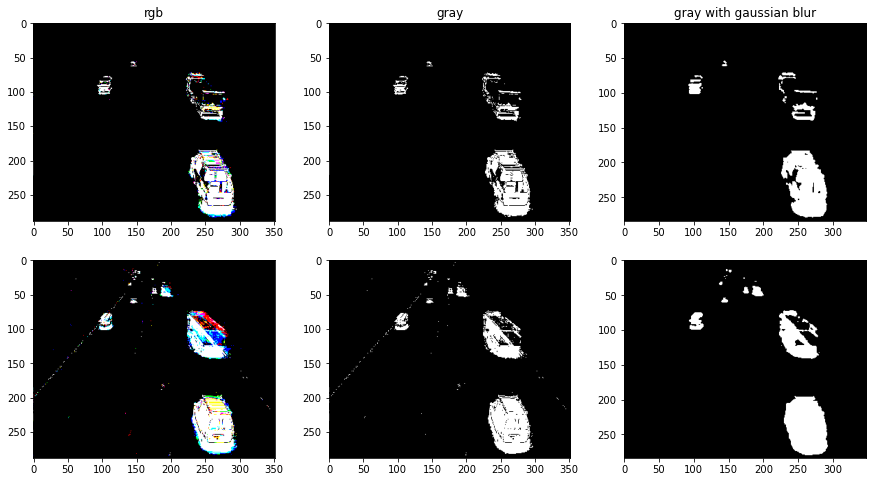


Plotting frames 1 and 80 for threshold: 0.2



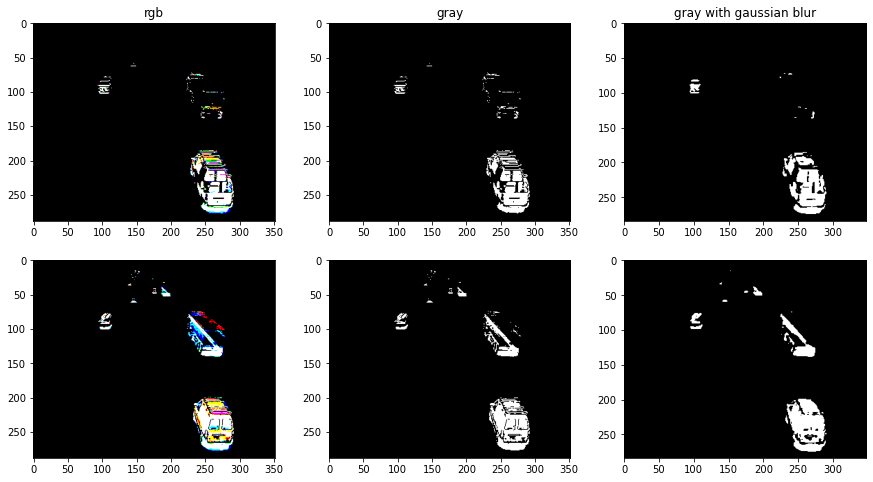


Plotting frames 1 and 80 for threshold: 0.4



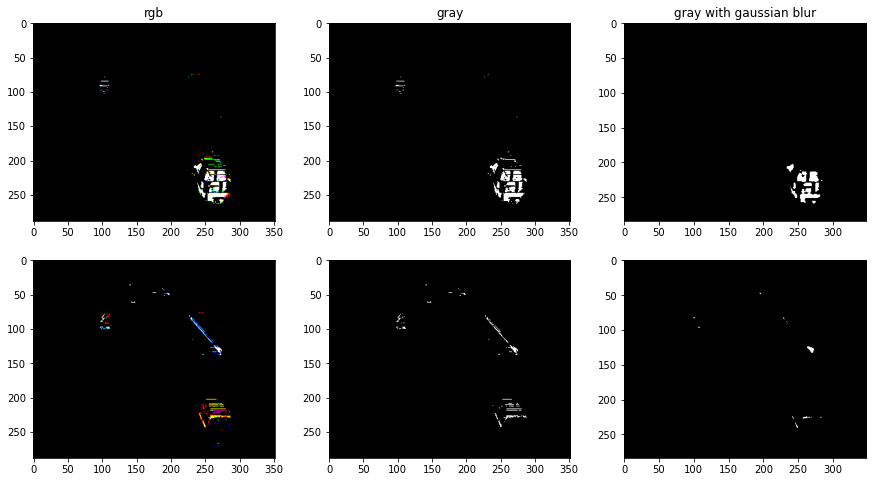

In [1120]:
thresholds = [0.05, 0.1, 0.2,0.4]
for t in thresholds:
    difference_matrix_comb = np.array(difference_frames)
    difference_matrix_comb = np.where(difference_matrix_comb > t, 1.0, 0.0)
    gray_scale_difference_comb = np.array(gray_scale_difference_frames)
    gray_scale_difference_comb = np.where(gray_scale_difference_comb > t, 1, 0)
    blurred_gray_comb = np.array(blurred_gray_scale_difference_frames)
    blurred_gray_comb = np.where(blurred_gray_comb > t, 1, 0)
    print(f"\nPlotting frames 1 and 80 for threshold: {t}\n")
    plot_images(difference_matrix_comb, gray_scale_difference_comb, blurred_gray_comb,1,80)

---

B) Repeat the exercise but using the previous frame as the reference point

In [272]:
gauss_filter = gaussian_filter(3,1)

cap = cv2.VideoCapture('DatasetC.mpg')
suc, frameT = cap.read()
frameT = frameT / 255
suc, frameTplus1 = cap.read()
frameTplus1 = frameTplus1 / 255

difference_frames = []
gray_scale_difference_frames = []
blurred_gray_scale_difference_frames = []

while suc:
    
    difference_matrix = np.abs(frameTplus1 - frameT)
    difference_frames.append((difference_matrix).copy())
    gray_scale_difference_frames.append(rgb2gray(difference_matrix))
    blurred_gray_scale_difference_frames.append(convolve_image(rgb2gray(difference_matrix),gauss_filter))
    frameT= frameTplus1.copy()
    suc, frameTplus1 = cap.read()
    if suc:
        frameTplus1 = frameTplus1 / 255

---

Note: frame 1 will be identical to the previous analysis, so i've used 15 and 80 for this.

I've also experimented with reduced thresholds as the differences are likely to be smaller


Plotting frames 15 and 80 for threshold: 0



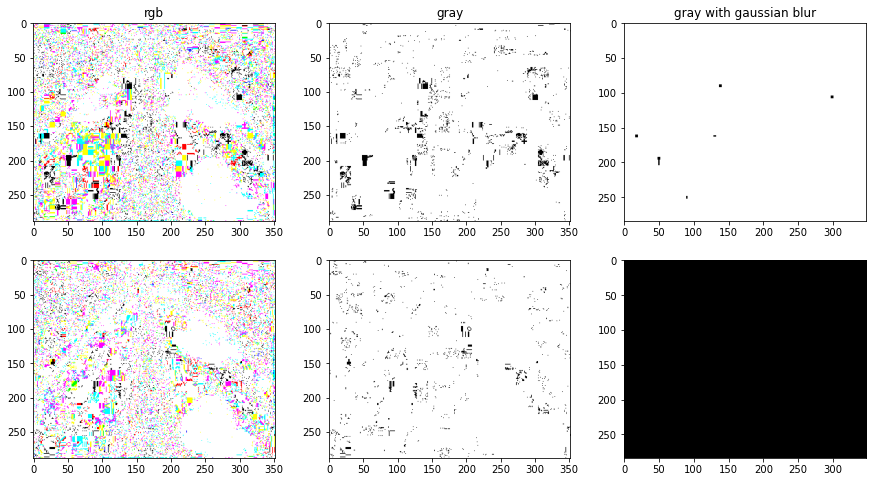


Plotting frames 15 and 80 for threshold: 0.02



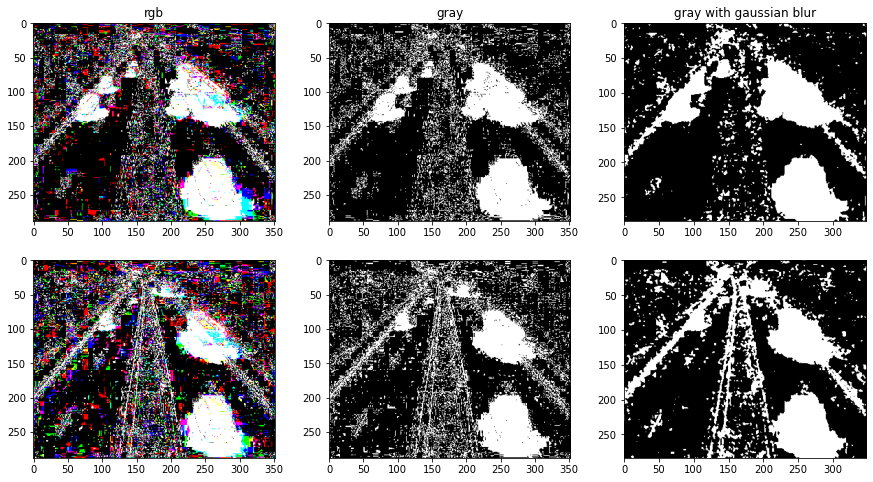


Plotting frames 15 and 80 for threshold: 0.06



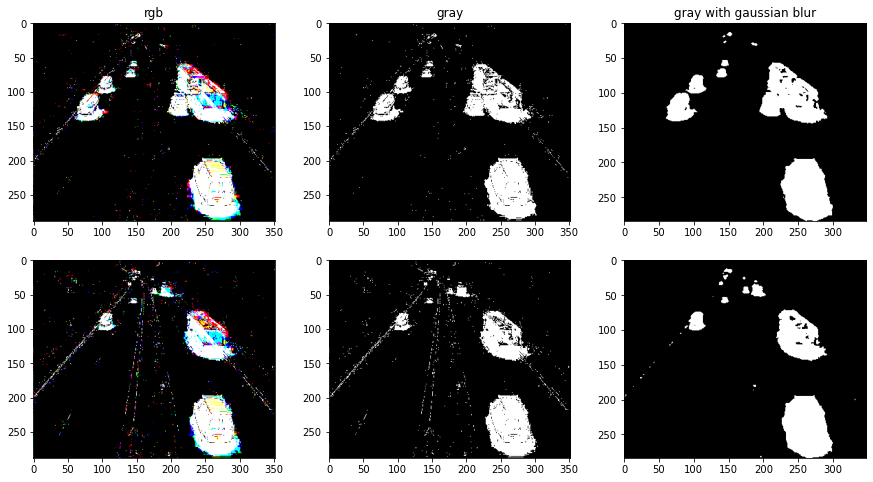


Plotting frames 15 and 80 for threshold: 0.15



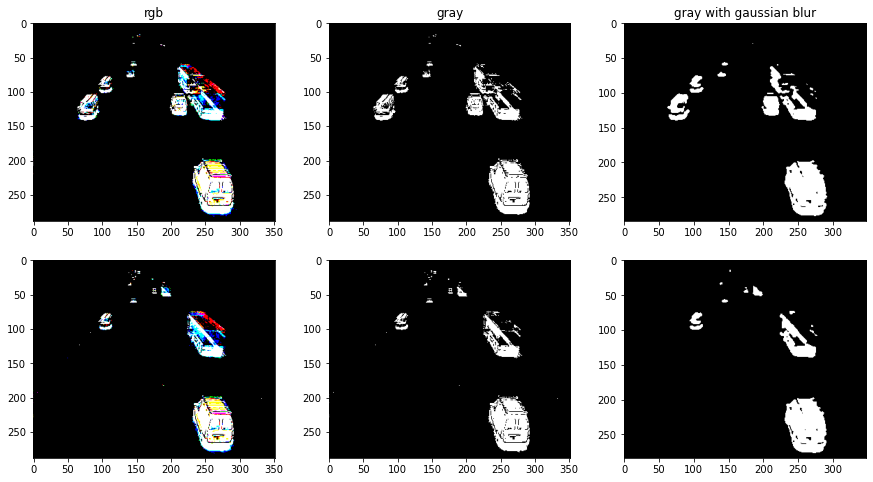

In [1122]:
thresholds = [0, 0.02, 0.06, 0.15]
for t in thresholds:
    difference_matrix_comb = np.array(difference_frames)
    difference_matrix_comb = np.where(difference_matrix_comb > t, 1.0, 0.0)
    gray_scale_difference_comb = np.array(gray_scale_difference_frames)
    gray_scale_difference_comb = np.where(gray_scale_difference_comb > t, 1, 0)
    blurred_gray_comb = np.array(blurred_gray_scale_difference_frames)
    blurred_gray_comb = np.where(blurred_gray_comb > t, 1, 0)
    print(f"\nPlotting frames 15 and 80 for threshold: {t}\n")
    plot_images(difference_matrix_comb, gray_scale_difference_comb, blurred_gray_comb,15,80)

OBSERVATION: the cars in the distance get blurred to the point they barely show up

What happens if we enlarge the image 4x (2 x 2) ?

NOTE: I ALSO TRIED ENLARGING 16X but this causes memory overload on Linux

I have used the open CV implementation of resizing upwards, which simply copies the cells 4x in each direction

In [278]:
gauss_filter = gaussian_filter(3,1)

cap = cv2.VideoCapture('DatasetC.mpg')
suc, frameT = cap.read()
frameT = frameT / 255
rows = frameT.shape[1]*2
cols = frameT.shape[0]*2
frameT = cv2.resize(frameT, (rows, cols))
suc, frameTplus1 = cap.read()
frameTplus1 = frameTplus1 / 255
frameTplus1 = cv2.resize(frameTplus1, (rows,cols))
difference_frames = []
gray_scale_difference_frames = []
blurred_gray_scale_difference_frames = []

while suc:
    
    difference_matrix = np.abs(frameTplus1 - frameT)
    difference_frames.append((difference_matrix).copy())
    gray_scale_difference_frames.append(rgb2gray(difference_matrix))
    blurred_gray_scale_difference_frames.append(convolve_image(rgb2gray(difference_matrix),gauss_filter))
    frameT= frameTplus1.copy()
    suc, frameTplus1 = cap.read()
    if suc:
        frameTplus1 = frameTplus1 / 255
        frameTplus1 = cv2.resize(frameTplus1,(rows,cols))


Plotting frames 15 and 80 for threshold: 0



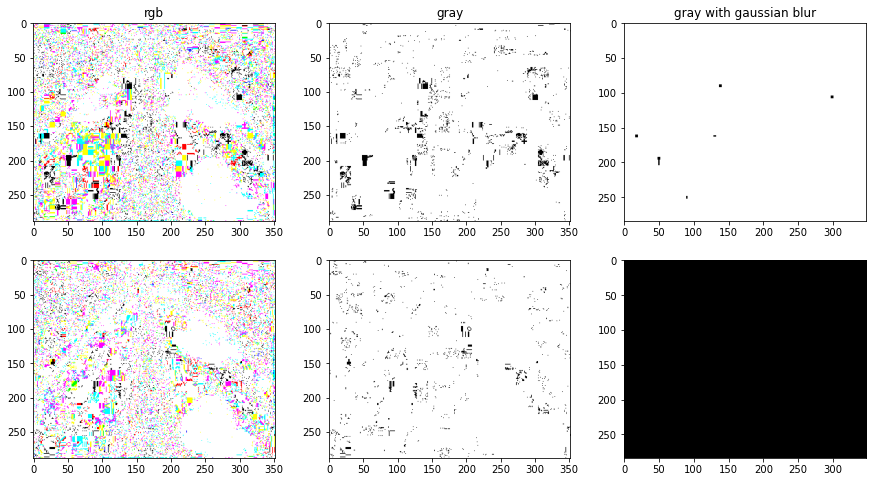


Plotting frames 15 and 80 for threshold: 0.02



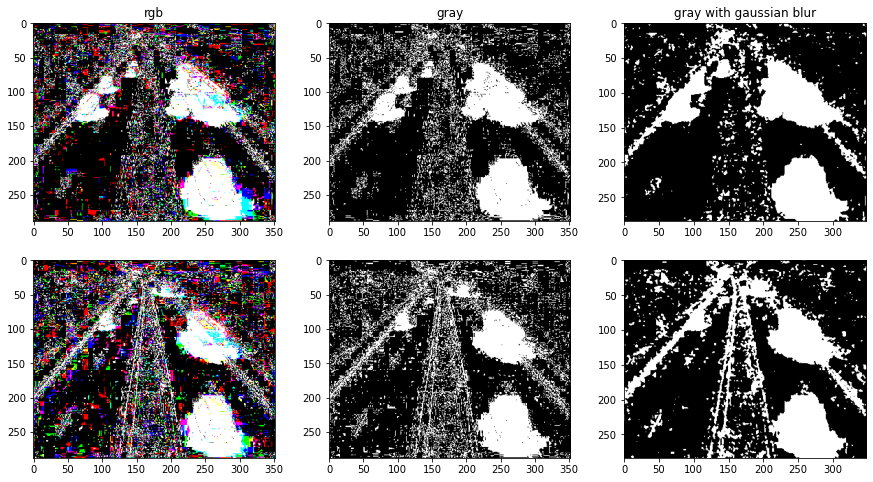


Plotting frames 15 and 80 for threshold: 0.06



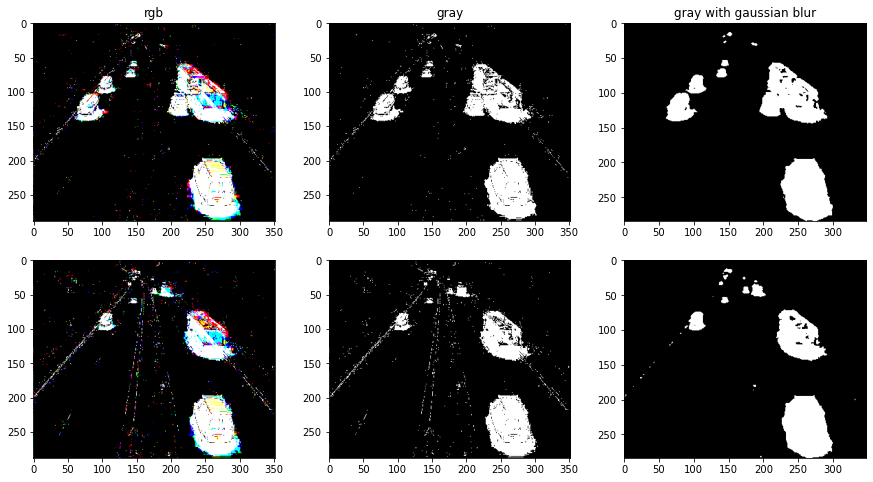


Plotting frames 15 and 80 for threshold: 0.15



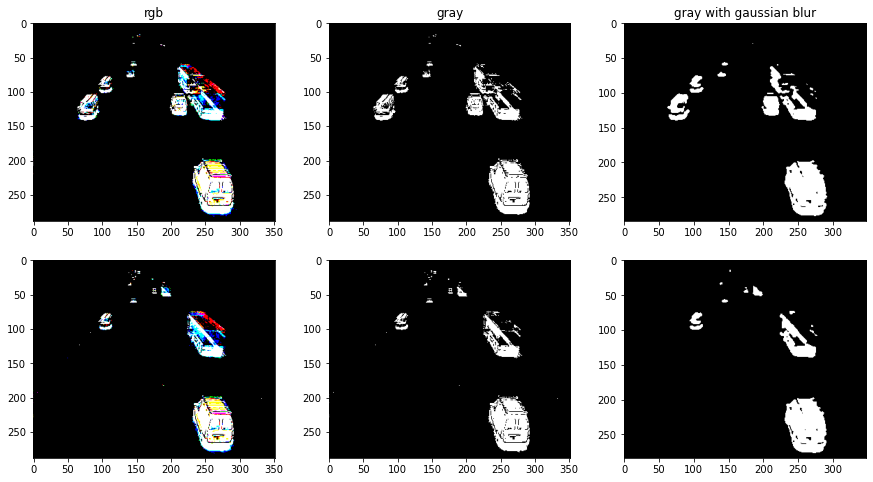

In [1123]:
thresholds = [0, 0.02, 0.06, 0.15]
for t in thresholds:
    difference_matrix_comb = np.array(difference_frames)
    difference_matrix_comb = np.where(difference_matrix_comb > t, 1.0, 0)
    gray_scale_difference_comb = np.array(gray_scale_difference_frames)
    gray_scale_difference_comb = np.where(gray_scale_difference_comb > t, 1, 0)
    blurred_gray_comb = np.array(blurred_gray_scale_difference_frames)
    blurred_gray_comb = np.where(blurred_gray_comb > t, 1, 0)
    print(f"\nPlotting frames 15 and 80 for threshold: {t}\n")
    plot_images(difference_matrix_comb, gray_scale_difference_comb, blurred_gray_comb,15,80)

This doesn't seem to make a big difference

----

----

Background Generation

for each pixel location, create three arrays

1) a list of the pixel value in that array

2) the temporal difference between that frame and t-1, the TD between that frame and t-2

Take an average that is excludes any of the pixel values when the TD is > threshold value

In [1139]:
#### CREATE THE THREE ARRAYS

frames_used = frame_count-1
# gauss_filter = gaussian_filter(3,1)

cap = cv2.VideoCapture('DatasetC.mpg')
suc, frameT = cap.read()
frameT = frameT / 255
suc, frameTplus1 = cap.read()
frameTplus1 = frameTplus1 / 255

##create empty arrays
pixel_val = np.zeros((int(frames_used),frameT.shape[0],frameT.shape[1],frameT.shape[2]))
tminus1_vals = np.zeros((int(frames_used), frameT.shape[0],frameT.shape[1],frameT.shape[2]))
idx=0

while suc:
    
    pixel_val[idx] = frameTplus1
    tminus1_vals[idx] += np.expand_dims(rgb2gray(np.abs(frameTplus1 - frameT)),axis=2)
     
    frameT= frameTplus1.copy()
    
    suc, frameTplus1 = cap.read()
    if suc:
        frameTplus1 = frameTplus1 / 255
    idx+=1
    
#### CREATE WEIGHTED AVERAGE BASED ON THRESHOLD



25.921568627450963

Background using threshold: 0.02


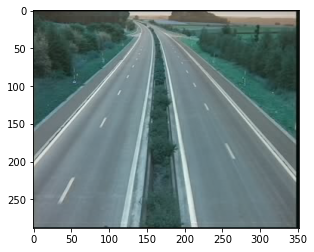

Background using threshold: 0.02


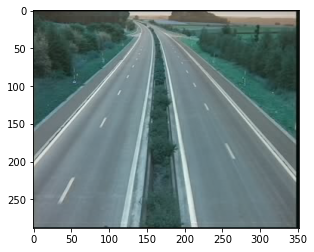

In [1150]:
def create_background(tminus1_vals, pixel_val,threshold):

    weighted_pixel_vals = np.where(tminus1_vals  < threshold, 1.0,0.0)
    cleaned_pixel_vals = weighted_pixel_vals * pixel_val
    background = np.sum(cleaned_pixel_vals,axis=0) / np.sum(weighted_pixel_vals,axis=0)
    
    return background
threshold = 0.02
background_002 = create_background(tminus1_vals,pixel_val, threshold=threshold)
print(f"Background using threshold: {threshold}")
plt.imshow(background_002); plt.show()
threshold = 0.05
background_005 = create_background(tminus1_vals,pixel_val, threshold=threshold)
print(f"Background using threshold: {threshold}")
plt.imshow(background_005); plt.show()


---

Doesn't appear that we need to use the second order for removal, and 0.05 is a good threshold, 0.02 is not

----


#### Counting images in a frame

Option 1: Use the background and when the pixels are significantly different to the background, count that section as one.

Option 2: use a temporal - [-1,-2,-3,0,3,2,1] filter

for either 1 or 2, perform some lookup which looks for a certain number of cells over a threshold in a square, rectangle (of 2 or 3 sizes), and pick the largest one that has some % of values over treshhold

----

In [1154]:
background = create_background(tminus1_vals,pixel_val,0.05)

In [1155]:
cap = cv2.VideoCapture('DatasetC.mpg')
suc, frameT = cap.read()
frameT = frameT/255
blank_vid_array = np.zeros((int(frame_count),frameT.shape[0], frameT.shape[1]))
idx=0
while suc:
    frameT = convolve_image(frameT, gaussian_filter(5,1),padding=True)
    blank_vid_array[idx] = rgb2gray(np.abs(frameT - background))
    idx +=1
    suc,frameT = cap.read()
    if suc:
        frameT = frameT/255

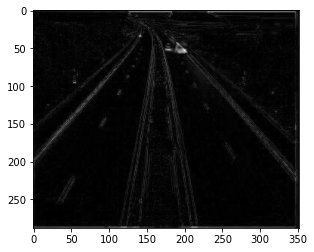

In [1156]:
plt.imshow(blank_vid_array[70],'gray'); plt.show()

---

We're getting this interesting issue of the lines where the cars often obscure. Maybe the median would be better and a higher threshold

In [1172]:
threshold = 0.1
final_pixel_vals = np.where(tminus1_vals  < threshold, pixel_val,0)
background = np.median(pixel_val,axis=0)

In [1180]:
cap = cv2.VideoCapture('DatasetC.mpg')
suc, frameT = cap.read()
frameT = frameT/255
blank_vid_array = np.zeros((int(frame_count),frameT.shape[0], frameT.shape[1],frameT.shape[2]))
idx=0
while suc:
    blank_vid_array[idx] = (frameT - background)
    idx +=1
    suc,frameT = cap.read()
    if suc:
        frameT = frameT/255

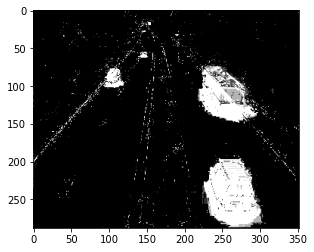

In [1190]:
plt.imshow((rgb2gray(np.where(np.abs(blank_vid_array[0]) > 0.05, 1.0,0))),'gray'); plt.show()

---

---

Method two, using a temporal filter


In [1612]:
cap = cv2.VideoCapture('DatasetC.mpg')
suc, frameT = cap.read()
frameT = frameT/255
blank_vid = np.zeros((int(frame_count),frameT.shape[0], frameT.shape[1],frameT.shape[2]))
idx=0
while suc:
    blank_vid[idx] = frameT
    suc, frameT = cap.read()
    if suc:
        frameT = frameT/255
        idx+=1

In [1691]:
Filter = (np.array([[-1],[-2],[-4],[0],[4],[2],[1]])).T
def convolve4dVideo(vid, Filter):
    ends = Filter.shape[0] //2
    new_vid = np.zeros_like(vid)[ends:len(vid)-ends]
    print(new_vid.shape)
    for i in range(ends,len(vid)-ends):
        for r, row in enumerate(vid[i]):
            for c, col in enumerate(vid[i][r]):
                for ch, chan in enumerate(vid[i][r][c]):
                    val = np.sum(Filter * vid[i-ends:i+ends+1,r,c,ch])
                
                    new_vid[i-ends][r][c][ch] = val
    
    return new_vid
    

In [1692]:
convolved_vid = convolve4dVideo(blank_vid[:10],Filter)

(10, 288, 352, 3)


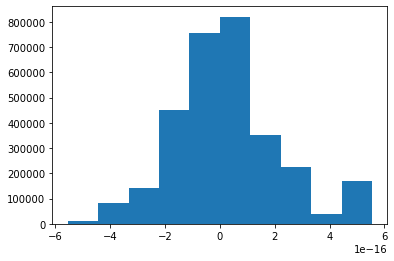

In [1693]:
plt.hist(convolved_vid.flatten()); plt.show()

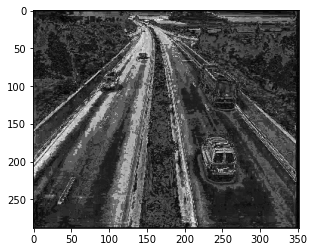

In [1699]:
plt.imshow(rgb2gray(np.abs(convolved_vid[3])/np.max(convolved_vid[3])),'gray')

---

OK this doesn't work as well, I'll use the background approach.

Pipeline:

- subtract background from image

- find shadows using HSV colour channels

to look for objects, I'll propose 9 bounding boxes of different shapes

1) Square shapes, of size (8,8), (16,16),(32,32)

2) Tall rectangles of (8, 16) and (16, 32)

3) Wide rectangles of (16,8) and (32,16)

find shapes where at least 50% of the box is "correct". Then prune by removing the smallest of any two overlapping boxes

--- 

CONVERTING TO HSV COLOUR SPACE TO BRING OUT COLOUR CHANGE AND REMOVE SHADOWS

In [1217]:
from IPython.display import clear_output

def bounding_boxes_and_object_detection(background, video, bounding_boxes,intersection_thresh,frames_to_run):
    
    def create_all_frames(video,background,frames_to_run):
        
        def convert_to_hsv(image):
            hsv_im = np.zeros_like(image)
            for r, row in enumerate(image):
                for c, col in enumerate(row):
                    max_rgb = np.max(image[r,c])
                    max_channel = np.argmax(image[r,c])
                    min_rgb = np.min(image[r,c])

                    hsv_im[r,c,2] = max_rgb #value
                    hsv_im[r,c,1] = (max_rgb-min_rgb) / (max_rgb+1e-10) #saturation
                    if max_channel == 0:
                        hsv_im[r,c,0] = (hsv_im[r,c,1] - hsv_im[r,c,2]) / (max_rgb-min_rgb + 1)
                    elif max_channel == 1:
                        hsv_im[r,c,0] = 2 + (hsv_im[r,c,2] - hsv_im[r,c,0]) / (max_rgb-min_rgb + 1)
                    else:
                        hsv_im[r,c,0] = 4 + (hsv_im[r,c,0] - hsv_im[r,c,1]) / (max_rgb-min_rgb + 1)
                    hsv_im[r,c,0]*=60
                    hsv_im[r,c,1]
                    hsv_im[r,c,2]

            return hsv_im

        def create_foreground(im, background):
            detection = im - background
            rgbDetection = np.max(detection,axis=2)
            hsv_im = convert_to_hsv(im)
            hsv_background = convert_to_hsv(background)
            comp = (hsv_im- hsv_background)

            shadow_im = np.zeros((im.shape[0], im.shape[1]))
            brightness_change = comp[:,:,2]
            image_copy = detection.copy()
            sat_chg = comp[:,:,1]
            for r, row in enumerate(shadow_im):
                for c, col in enumerate(row):

                    if ( comp[r,c,2] < 0 and np.abs(comp[r,c,2]) > 12*np.abs(comp[r,c,1]) ):
                        
                        if np.abs(rgbDetection[r,c]) > 0.1:
                            shadow_im[r,c,] = 1
                            image_copy[r,c] = 0

            image_copy = np.abs(rgb2gray(image_copy))
            image_copy = convolve_image(image_copy - shadow_im,gaussian_filter(7,1.5),padding=True)
            image_copy = np.where(image_copy > 0.08, 1.0, 0)
            return image_copy

        cap = cv2.VideoCapture('DatasetC.mpg')
        suc, frameT = cap.read()
        frameT = frameT/255
        vid_array = np.zeros((int(frame_count),frameT.shape[0], frameT.shape[1],frameT.shape[2]))
        vid_foreground = np.zeros((int(frame_count),frameT.shape[0], frameT.shape[1]))
        idx=0
        while suc and idx < frames_to_run:
            clear_output()
            print(idx)
            vid_foreground[idx] = create_foreground(frameT,background)
            vid_array[idx] = frameT
            idx +=1
            suc,frameT = cap.read()
            if suc:
                frameT = frameT/255
        return vid_array, vid_foreground
    
    def find_bbs(frame, bounding_boxes):
        list_of_candidates = []
        for key,val in bounding_boxes.items():    
            bb_height, bb_width,step_size, threshold = val;

            for r in range(0,frame.shape[0] - bb_height,step_size):
                for c in range(0,frame.shape[1] - bb_width,step_size):
                    summed_val = np.mean(frame[r:r+bb_height,c:c+bb_width])
                    if summed_val > threshold:
                        list_of_candidates.append([r,c,summed_val, key,bb_height,bb_width])
        boxes = np.array(list_of_candidates)
        if len(boxes) > 0:
            boxes_priority = np.array(pd.DataFrame(boxes).sort_values(by=[3,2],ascending=[True,False]))
            boxes_priority = np.append(boxes_priority,np.expand_dims(boxes_priority[:,0] + boxes_priority[:,4],axis=1),axis=1)
            boxes_priority = np.append(boxes_priority,np.expand_dims(boxes_priority[:,1] + boxes_priority[:,5],axis=1),axis=1)
            return boxes_priority, True
        else:
            return [], False

    def only_keep_good_bounding_boxes(boxes_priority,intersection_thresh=0.3):
    
        def calculate_intersection(bb1,bb2):
            if bb1[0] <= bb2[0]: #if top of bigger boxes is to the top of top o smaller box
                vertical_intersection = max(0,min(bb1[6]-bb2[0],bb2[4])) #
            else:
                vertical_intersection = max(0, bb2[6] - bb1[0])

            if bb1[1] <= bb2[1]:
                horizontal_intersection = max(0,min(bb1[7]-bb2[1],bb2[5]))
            else:
                horizontal_intersection = max(0, bb2[7] - bb1[1])
            total_intersection = horizontal_intersection*vertical_intersection
            intersection = total_intersection / max(bb2[4]*bb2[5],bb1[4]*bb2[5])
            return intersection

        boxes_to_keep = {}
        counter = 0

        for i, row in enumerate(boxes_priority):
            success = True
            for row2 in boxes_priority[:i]:
                #work out the correct way to do the intersection
                if calculate_intersection(row, row2) > intersection_thresh:
                    success=False
                    break
            if success:
                boxes_to_keep[tuple((row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7]))] = row[2]

        return boxes_to_keep
    
    def convert_np_to_pil(npIm):
        uint8_form = (npIm*255).astype('uint8')
        return Image.fromarray(uint8_form)

    def draw_bounding_box_on_image(image,
                               coordinates,
                               color = 'white',
                               thickness=2,
                               display_str_list=()):
        """Adds a bounding box to an image."""
        draw = ImageDraw.Draw(image)
        im_width, im_height = image.size
        (top, left, _,_,_,_,bottom, right) = coordinates
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                 (left, top)],
                width=thickness,
                fill=color)
    
    #### CALLING ABOVE FUNCTIONS
    
    video_frames, vid_foreground = create_all_frames(video, background,frames_to_run)
    video_frames_copy = video_frames.copy()
    object_count = []
    print("finished first section")
    for f, frame in enumerate(vid_foreground):
        if f >= frames_to_run:
            break
        bbs, suc = find_bbs(frame, bounding_boxes)
        if suc != False:
            bbs = only_keep_good_bounding_boxes(bbs, intersection_thresh)
            frame_Im = convert_np_to_pil(video_frames[f])
            for keys in bbs.keys():
                draw_bounding_box_on_image(frame_Im,list(keys))
            np_image = np.array(frame_Im)
            video_frames_copy[f] = np_image.copy()/255
            object_count.append(len(bbs))
        else:
            object_count.append(0)
    return video_frames_copy,video_frames, object_count

In [1218]:
####### NOTE: This takes about 5 minutes to run.

# You can also load annotated frames from the saved folder in next cell

video_file = 'DatasetC.mpg'
bounding_boxes = {1: (64,64,8,0.28),
                 2: (48,72,8,0.28),
                 3: (48,72,8,0.28),
                 4: (48,48,6,0.3),
                 5: (32,64,6,0.3),
                 6: (32,64,6,0.3),
                 7: (32,32,4,0.45),
                 8: (16,32,4,0.45),
                 9: (32, 16,4,0.45),
                 10: (16,16,4,0.45),
                 11: (16,8,2,0.6),
                 12: (8,16,2,0.6)}
# bb_threshold = 0.4
intersection_thresh = 0.1
frames_to_run = 200
video_frames_copy,video_frames, object_count = bounding_boxes_and_object_detection(background, video_file, bounding_boxes,intersection_thresh,frames_to_run)
save('vidFrames.npy', video_frames_copy)

139
finished first section


In [1103]:
annotated_frames = load('vidFrames.npy')

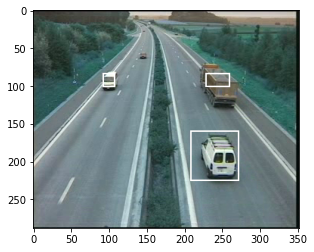

In [1225]:
plt.imshow(annotated_frames[3]);plt.show()

In [ ]:
plt.plot(list(range(len(object_count))),object_count) 
plt.xlabel('frame')
plt.ylabel('objects')
plt.show()

----

END OF MARKABLE ASSIGNMENT

In [1206]:
# ### BLANKED OUT. USED FOR BUG CHECKING PURPOSES FOR REPORT ONLY.

# def convert_to_hsv(image):
#         hsv_im = np.zeros_like(image)
#         for r, row in enumerate(image):
#             for c, col in enumerate(row):
#                 max_rgb = np.max(image[r,c])
#                 max_channel = np.argmax(image[r,c])
#                 min_rgb = np.min(image[r,c])

#                 hsv_im[r,c,2] = max_rgb #value
#                 hsv_im[r,c,1] = (max_rgb-min_rgb) / (max_rgb+1e-10) #saturation
#                 if max_channel == 0:
#                     hsv_im[r,c,0] = (hsv_im[r,c,1] - hsv_im[r,c,2]) / (max_rgb-min_rgb + 1)
#                 elif max_channel == 1:
#                     hsv_im[r,c,0] = 2 + (hsv_im[r,c,2] - hsv_im[r,c,0]) / (max_rgb-min_rgb + 1)
#                 else:
#                     hsv_im[r,c,0] = 4 + (hsv_im[r,c,0] - hsv_im[r,c,1]) / (max_rgb-min_rgb + 1)
#                 hsv_im[r,c,0]*=60
#                 hsv_im[r,c,1]
#                 hsv_im[r,c,2]

#         return hsv_im

# def create_foreground(im, background):
#     detection = im - background
#     rgbDetection = np.max(detection,axis=2)
#     hsv_im = convert_to_hsv(im)
#     hsv_background = convert_to_hsv(background)
#     comp = (hsv_im- hsv_background)

#     shadow_im = np.zeros((im.shape[0], im.shape[1]))
#     brightness_change = comp[:,:,2]
#     image_copy = detection.copy()
#     sat_chg = comp[:,:,1]
#     for r, row in enumerate(shadow_im):
#         for c, col in enumerate(row):

#             if ( comp[r,c,2] < 0 and np.abs(comp[r,c,2]) > 12*np.abs(comp[r,c,1]) ):

#                 if np.abs(rgbDetection[r,c]) > 0.1:
#                     shadow_im[r,c,] = 1
#                     image_copy[r,c] = 0

#     image_copy = np.abs(rgb2gray(image_copy))
#     image_copy = convolve_image(image_copy - shadow_im,gaussian_filter(7,1.5),padding=True)
#     image_copy = np.where(image_copy > 0.08, 1, 0)
#     return image_copy

---- 
--- 
### PLEASE DO NOT MARK BELOW. THIS WAS EXPERIMENTATION WITH TEXTURE BASED CLUSTERING WHICH I HAVE NOT USED IN FINAL SUBMISSION

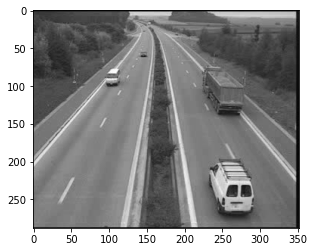

In [861]:
cap = cv2.VideoCapture('DatasetC.mpg')
suc, frameT = cap.read()
frameT = frameT / 255
plt.imshow(rgb2gray(frameT),'gray')

In [858]:
coloured_frames = frameT / (np.expand_dims(np.mean(frameT,axis=2),2) +1e-5) /3

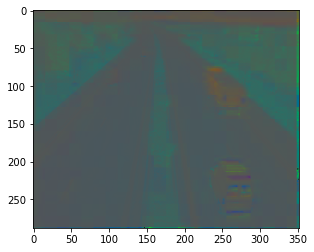

In [859]:
plt.imshow(coloured_frames)

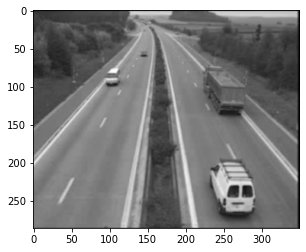

In [937]:
plt.imshow(gs_change,'gray')

In [877]:
canny_edge = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
new_im_v = np.abs(convolve_image(rgb2gray(frameT),canny_edge,padding=True))
# new_im_v = np.where(new_im_v>0.4,new_im_v,0)
new_im_h = np.abs(convolve_image(rgb2gray(frameT),canny_edge.T,padding=True))
# new_im_h = np.where(new_im_h>0.4,new_im_h,0)

In [902]:
def max_pad(array,size=15):
    dist = size //2
    blank_array = np.zeros_like(array)
    padded_im = np.pad(array,((dist,dist),(dist,dist)))
    for r in range(dist, padded_im.shape[0]-dist):
        for c in range(dist, padded_im.shape[1]-dist):
            blank_array[r-dist,c-dist] = np.max(padded_im[r-dist:r+dist,c-dist:c+dist])
    return blank_array

In [1000]:
gradient_directions = np.arctan(new_im_h / (new_im_v+1e-10))
gradient_mag = (new_im_h**2 + new_im_v**2)**0.5
gradient_mag = np.where(gradient_mag>0.3,1,0)

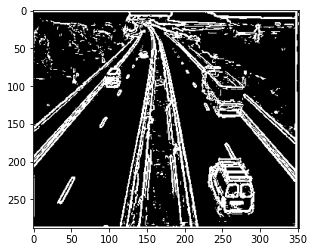

In [1010]:
plt.imshow(gradient_mag,'gray'); plt.show()

In [1003]:
#having a look at change in colour
col_chg_v = np.max(np.abs(convolve_image(coloured_frames,canny_edge,True)),axis=2)
col_chg_h = np.max(np.abs(convolve_image(coloured_frames,canny_edge.T,True)),axis=2)

col_chg_v /= np.max(col_chg_v)
col_chg_v = np.where(col_chg_v>0.04,1,0)
col_chg_h /= np.max(col_chg_h)
col_chg_h = np.where(col_chg_h>0.04,1,0)


col_chg = col_chg_h+col_chg_v
col_and_grad_diff = col_chg-gradient_mag
col_and_grad_diff = np.where(col_and_grad_diff>0.2,1,col_and_grad_diff)
col_and_grad_diff = np.where(col_and_grad_diff<-0.2,-1,col_and_grad_diff)
col_and_grad_diff = np.where(col_and_grad_diff**2==1,col_and_grad_diff,0)

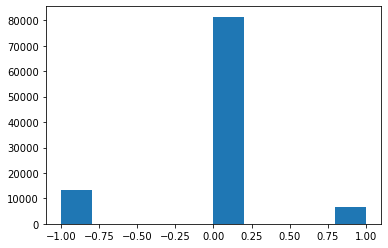

In [1008]:
plt.hist(col_and_grad_diff.flatten());plt.show()

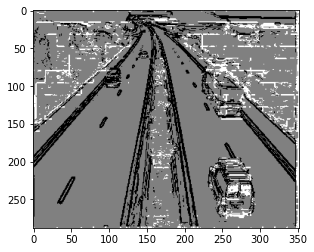

In [1009]:
plt.imshow(col_and_grad_diff,'gray'); plt.show()

In [912]:
### then append this to the values
combined = np.concatenate((np.expand_dims(gradient_directions,axis=2),
                           np.expand_dims(gradient_mag,axis=2),
                           coloured_frames,
                           np.expand_dims(rgb2gray(frameT),axis=2)),axis=2)


In [913]:
combined.shape

(288, 352, 6)

In [914]:
def cluster_algorithm(laws_texture_output,channels,no_of_clusters=6):
    
    def assign_pixel_to_cluster(pixel, cluster_mid,clusters_babies):

        def distance_to_cluster(pixel, cluster_point):
            return np.mean(np.sqrt((pixel - (cluster_point))**2))
        
        best_dist = float('inf')
        best_cluster = 0;
        for key, val in cluster_mid.items():

            candidate_val = distance_to_cluster(pixel, val)
            if candidate_val < best_dist:
                best_dist = candidate_val
                best_cluster = key
        
        clusters_babies[best_cluster].append(pixel)
    
    #pick x cluster centre points at random
    clusters_babies = {}
    cluster_mid = {}
    for i in range(no_of_clusters):
        
        cluster_mid[i] = np.random.uniform(size=channels)
        clusters_babies[i] = []
    
    for it in range(20):
        print(it)
        #assign all pixels to a cluster
        for row_idx, row in enumerate(laws_texture_output):
            for col_idx, col in enumerate(laws_texture_output[row_idx]):
                assign_pixel_to_cluster(laws_texture_output[row_idx,col_idx],cluster_mid, clusters_babies)

        #Move cluster to central point in the cluster
        for key in cluster_mid.keys():
            #each of the 10 vals
            for i in range(channels):
                mean_val = 0;
                for x in clusters_babies[key]:
                    mean_val += (x[i] - cluster_mid[key][i])
                mean_val /= len(clusters_babies[key])+1e-5
                cluster_mid[key][i] = mean_val
    
    return cluster_mid

In [917]:
clusters = cluster_algorithm(combined,6,12)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [782]:
def assign_pixel_to_cluster(pixel, clusters):

    def distance_to_cluster(pixel, cluster_point):
        return np.mean(np.sqrt(((pixel - (cluster_point))**2)))
        
    best_dist = float('inf')
    best_cluster = 0;
    for key, val in clusters.items():
        candidate_val = distance_to_cluster(pixel, val)
        if candidate_val < best_dist:
            best_dist = candidate_val
            best_cluster = key
    return best_cluster

def create_clustered_image(laws_texture,cluster):
    shapes_for_laws_texture = np.zeros((laws_texture.shape[0],laws_texture.shape[1]))
    for row_i, row in enumerate(shapes_for_laws_texture):
        for col_j, col in enumerate(row):
            shapes_for_laws_texture[row_i, col_j] = assign_pixel_to_cluster(laws_texture[row_i,col_j],clusters)
    return shapes_for_laws_texture

In [919]:
im = create_clustered_image(combined, clusters)

In [920]:
im[100:]

array([[ 6.,  2.,  5., ...,  6.,  6.,  6.],
       [ 6.,  2.,  6., ...,  6.,  6.,  6.],
       [ 6.,  5.,  4., ...,  6.,  6.,  6.],
       ...,
       [ 2.,  4.,  4., ...,  6., 11.,  6.],
       [ 2.,  9.,  9., ...,  6.,  6.,  6.],
       [ 6.,  9.,  9., ...,  6., 11.,  6.]])

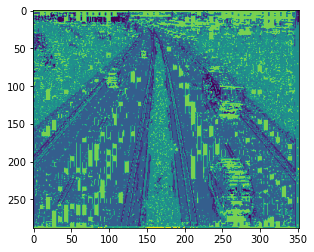

In [922]:
plt.imshow(im)

(array([ 1352.,  7280.,    67., 39582.,  7900., 20103.,  1843.,    11.,
        23145.,    93.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

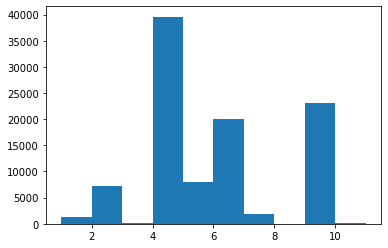

In [923]:
plt.hist(im.flatten())